In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
from matplotlib import pyplot as plt
import os 
import warnings
warnings.filterwarnings("ignore")

###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################

directory = os.path.normpath(os.getcwd() + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata/yielddata.csv"

yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 


In [2]:
# Fix parameters for building yield curve instruments
instrumentsconfig={
            "DEPO": {
                "businessDayConvention": "ModifiedFollowing",
                "dayCounter": "Actual365Fixed"
            },
            "FUTURES": {
                "businessDayConvention": "ModifiedFollowing",
                "dayCounter": "Actual365Fixed",
                "market": "IMM"            },
            "IRS": {
                "businessDayConvention": "ModifiedFollowing",
                "dayCounter": "Actual365Fixed",
                "frequency": "Semiannual"
            }
        } 

In [3]:
# Fix parameters for building yield curve
yieldcurveconfig={
        "settlementDays": 2,
        "intpMethod": "LOGLINEAR",
        "currency": "USD",
        "calendar": "UnitedStates",
        "dayCounter": "Actual365Fixed",
        "period": "3M",
        "instruments":instrumentsconfig}

In [4]:
creditCurveconfig= {
        "settlementDays": 2,
        "intpMethod": "LOGLINEAR",
        "currency": "USD",
        "calendar": "TARGET",
        "dayCounter": "Actual360",
        "period": "",
        "instruments": {
            "CDS": {
                "businessDayConvention": "ModifiedFollowing",
                "dayCounter": "Actual365Fixed",
                "frequency": "Quarterly"
            }
        }
    }

In [5]:
yieldcurve =  {
    "valuationDate": "2021-03-05",
    "yieldCurve":yieldcurveconfig ,
    "creditCurve":creditCurveconfig,
    "recoveryRate": 0.25,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, yieldcurve,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [6]:
hazardrates=result.get("hazardRates"),
survivalprobabilities=result.get("survivalProbabilities")
defaultprobabilities=result.get("defaultProbabilities")
hazardratesdicts = {}
survivalprobabilitiesdict = {}
defaultprobabilitiesdict = {}
for rhvzr in hazardrates[0]:
    hazardratesdicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
for rhvzr in survivalprobabilities:
    survivalprobabilitiesdict[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
for rhvzr in defaultprobabilities:
    defaultprobabilitiesdict[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100    


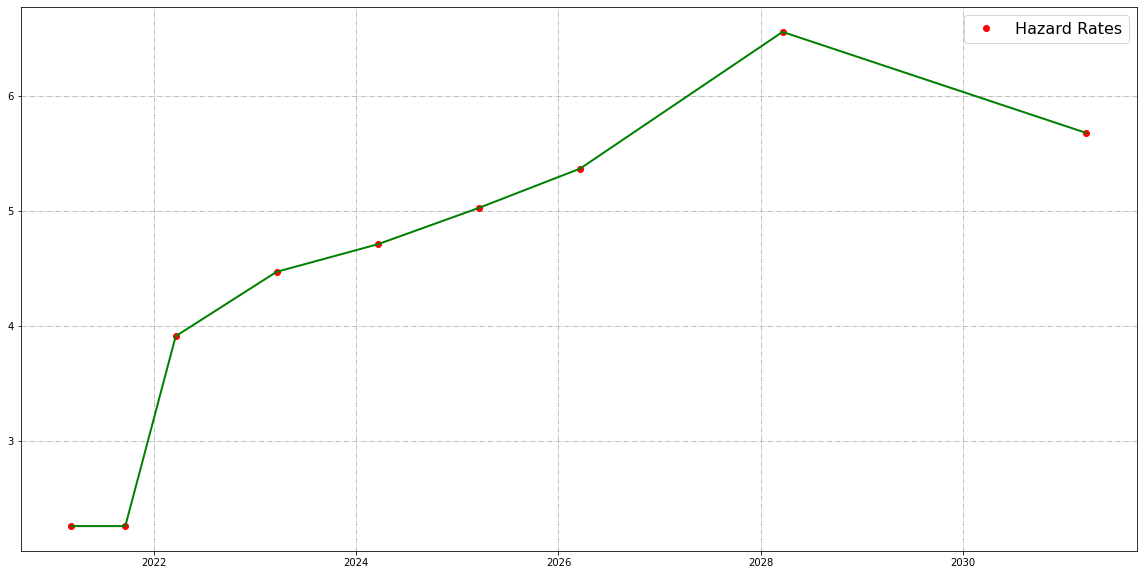

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(hazardratesdicts.keys())
y = list(hazardratesdicts.values())


ax.plot(x,y, 'ro', label='Hazard Rates', linewidth=2)
ax.plot(x,y, 'g', linewidth=2)

#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

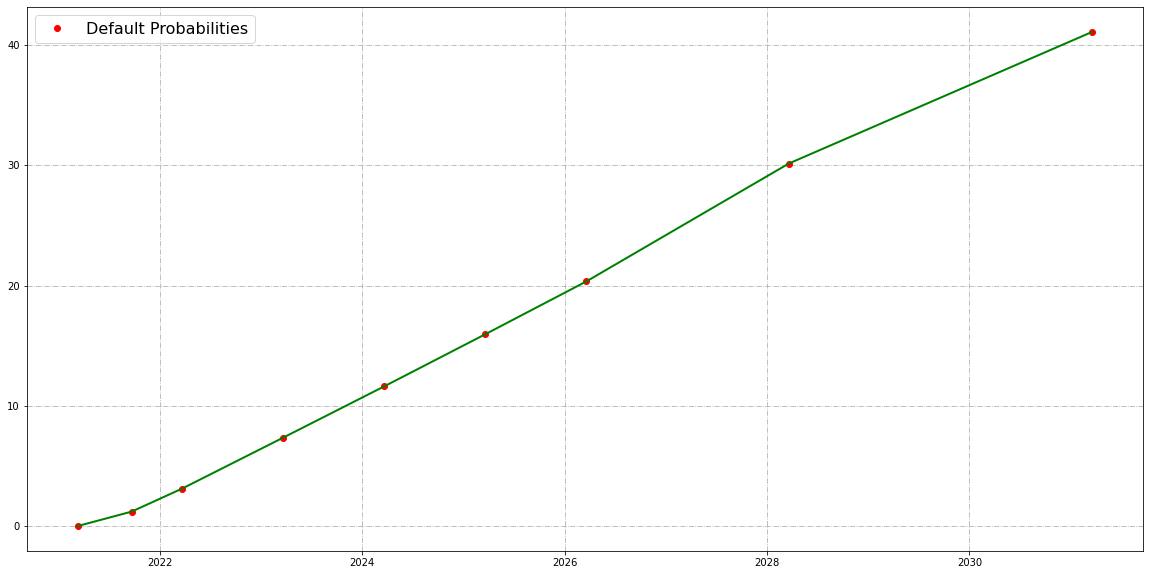

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(defaultprobabilitiesdict.keys())
y = list(defaultprobabilitiesdict.values())

ax.plot(x,y, 'ro', label='Default Probabilities', linewidth=2)
ax.plot(x,y, 'g', linewidth=2)

#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

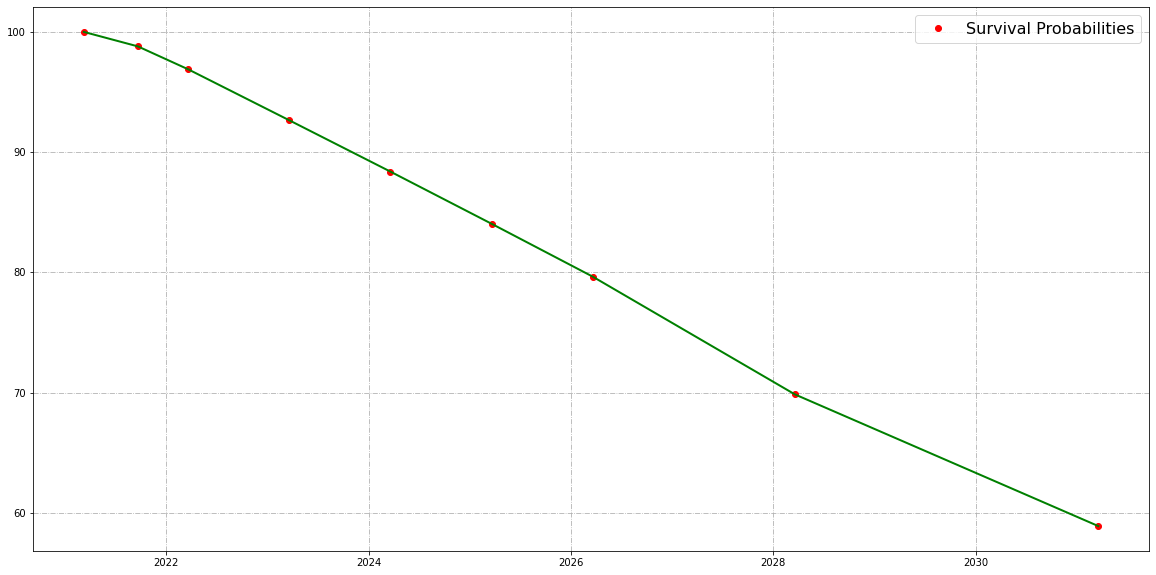

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(survivalprobabilitiesdict.keys())
y = list(survivalprobabilitiesdict.values())

ax.plot(x,y, 'ro', label='Survival Probabilities', linewidth=2)
ax.plot(x,y, 'g', linewidth=2)


#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [10]:
pTable = pt.PrettyTable(['Maturity','Hazard Rates','Default Probabilities','Survival Probabilities'])
i=0
for key, val in hazardratesdicts.items():
    pTable.add_row([key, val,defaultprobabilitiesdict.get(key),survivalprobabilitiesdict.get(key)])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+--------------+-----------------------+------------------------+
|  Maturity  | Hazard Rates | Default Probabilities | Survival Probabilities |
+------------+--------------+-----------------------+------------------------+
| 2021-03-09 |   2.264502   |           0           |          100           |
| 2021-09-20 |   2.264502   |        1.202514       |       98.797486        |
| 2022-03-21 |   3.915308   |        3.112622       |       96.887378        |
| 2023-03-20 |   4.474438   |        7.340872       |       92.659128        |
| 2024-03-20 |   4.714395   |       11.619235       |       88.380765        |
| 2025-03-20 |   5.030752   |       15.955465       |       84.044535        |
| 2026-03-20 |   5.371718   |       20.350986       |       79.649014        |
| 2028-03-20 |   6.559970   |       30.156953       |       69.843047        |
| 2031-03-20 |   5.683012   |       41.104766       |       58.895234        |
+------------+--------------+-----------------------